In [1]:
!nvidia-smi

Thu May 13 23:33:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1E:00.0 Off |                    0 |
| N/A   32C    P0    43W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sys
sys.path.append('../../')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import pandas as pd
import scipy
from tqdm import tqdm
import json
from scipy import stats
import matplotlib.pyplot as plt
from dateutil.parser import parse
from tqdm import tqdm
from typing import Tuple, List
import gzip
import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob 
from dateutil import parser
import dateutil
import transformers
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import re
import warnings
warnings.filterwarnings("ignore")
from scripts.get_train_test import normalize_target
from scripts.metrics import get_metrics, plot_two_distributions
from nltk.tokenize import regexp_tokenize, wordpunct_tokenize

In [5]:
def get_metrics(y_test, predicted_y):
    mse = round(mean_squared_error(y_test, predicted_y), 4)
    mae = round(mean_absolute_error(y_test, predicted_y),4)
    r = round(r2_score(y_test, predicted_y), 4)
    pearsonr_corr, pearsonr_corr_p = stats.pearsonr(y_test, predicted_y)
    spearman_corr, spearman_p = stats.spearmanr(y_test, predicted_y)
    print("Report:")
    print(f"mean_squared_error: {mse}\nmean_absolute_error: {mae}\nr2_score {r}")
    print(f"pearsonr_corr: {round(pearsonr_corr, 4)}, pearsonr_p: {round(pearsonr_corr_p, 4)}")
    print(f"spearman_corr: {round(spearman_corr, 4)}, spearman_p: {round(spearman_p, 4)}")
    print()
    return mse, mae, r, pearsonr_corr

In [6]:
def get_base_data():
    base_path = "../../data/Data DigitalFreud/final_data/"
    base_info_path = '1/item1.csv'

    base_info_file = os.path.join(base_path, base_info_path)
    base_info = pd.read_csv(base_info_file)
    base_info = base_info[(base_info.who_score.notna()) & (base_info.diener_score.notna())]
    return base_info

base_info = get_base_data()


In [7]:
base_info

,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,diener_2,diener_3,diener_4,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time
0,fa375bc4-a5ce-23df-7400-5c51954d4886,745443180,4.0,3.0,3.0,4.0,3.0,13.0,3.0,5.0,5.0,3.0,6.0,13.0,male,1984.0,"Среднее, сейчас не учусь",NaN,NaN,2018-06-12 06:40:08
1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,16.0,6.0,2.0,1.0,2.0,5.0,19.0,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22
2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,14.0,2.0,2.0,1.0,1.0,4.0,25.0,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11
3,fa5a0f03-8888-2d6f-7381-5300d0f370f6,95556615,3.0,3.0,3.0,3.0,3.0,15.0,5.0,5.0,5.0,5.0,5.0,10.0,male,2000.0,secondary,student,in_relationship,2018-09-13 07:45:18
4,fa52b45a-507a-20e3-6c4e-c158b74f4347,435358060,3.0,3.0,5.0,4.0,3.0,12.0,5.0,1.0,3.0,3.0,1.0,22.0,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-28 18:57:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,16.0,5.0,5.0,1.0,5.0,4.0,15.0,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08
2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,15.0,3.0,2.0,2.0,3.0,4.0,21.0,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00
2038,05ec148b-67f3-2b4d-71c9-53bee209805e,694243187,4.0,4.0,4.0,4.0,4.0,10.0,5.0,2.0,2.0,5.0,5.0,16.0,female,1995.0,secondary_special,unemployed,in_relationship,2019-09-05 05:32:31
2039,05e570f2-e074-219e-42da-d5117d5b13c3,418940323,2.0,0.0,1.0,4.0,4.0,19.0,5.0,4.0,5.0,5.0,5.0,11.0,female,2000.0,other,unemployed,single,2019-03-27 11:48:09


In [8]:
base_info_no_test = base_info[base_info.duplicated("vk_id_encrypted") == False]

In [9]:
base_info_no_test

,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,diener_2,diener_3,diener_4,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time
0,fa375bc4-a5ce-23df-7400-5c51954d4886,745443180,4.0,3.0,3.0,4.0,3.0,13.0,3.0,5.0,5.0,3.0,6.0,13.0,male,1984.0,"Среднее, сейчас не учусь",NaN,NaN,2018-06-12 06:40:08
1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,16.0,6.0,2.0,1.0,2.0,5.0,19.0,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22
2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,14.0,2.0,2.0,1.0,1.0,4.0,25.0,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11
3,fa5a0f03-8888-2d6f-7381-5300d0f370f6,95556615,3.0,3.0,3.0,3.0,3.0,15.0,5.0,5.0,5.0,5.0,5.0,10.0,male,2000.0,secondary,student,in_relationship,2018-09-13 07:45:18
4,fa52b45a-507a-20e3-6c4e-c158b74f4347,435358060,3.0,3.0,5.0,4.0,3.0,12.0,5.0,1.0,3.0,3.0,1.0,22.0,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-28 18:57:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,16.0,5.0,5.0,1.0,5.0,4.0,15.0,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08
2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,15.0,3.0,2.0,2.0,3.0,4.0,21.0,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00
2038,05ec148b-67f3-2b4d-71c9-53bee209805e,694243187,4.0,4.0,4.0,4.0,4.0,10.0,5.0,2.0,2.0,5.0,5.0,16.0,female,1995.0,secondary_special,unemployed,in_relationship,2019-09-05 05:32:31
2039,05e570f2-e074-219e-42da-d5117d5b13c3,418940323,2.0,0.0,1.0,4.0,4.0,19.0,5.0,4.0,5.0,5.0,5.0,11.0,female,2000.0,other,unemployed,single,2019-03-27 11:48:09


In [10]:
files = glob("../../data/proc_messages-date-user2/texts/*")
files[:10]

['../../data/proc_messages-date-user2/texts/311226232.json.gz',
 '../../data/proc_messages-date-user2/texts/55106467.json.gz',
 '../../data/proc_messages-date-user2/texts/282720738.json.gz',
 '../../data/proc_messages-date-user2/texts/122949173.json.gz',
 '../../data/proc_messages-date-user2/texts/220419749.json.gz',
 '../../data/proc_messages-date-user2/texts/90175295.json.gz',
 '../../data/proc_messages-date-user2/texts/137479231.json.gz',
 '../../data/proc_messages-date-user2/texts/609145811.json.gz',
 '../../data/proc_messages-date-user2/texts/695942899.json.gz',
 '../../data/proc_messages-date-user2/texts/52851195.json.gz']

In [11]:
# prepare data: for each user get messages in interval [freud_install_time - 3 months; freud_install_time]

In [12]:
from glob import glob
path_to_messages = "../../data/proc_messages-date-user2/texts/"
all_users_with_messages = [int(os.path.basename(f).split(".")[0]) for f in glob(os.path.join(path_to_messages, "*"))]
all_users_with_messages[:10]

[311226232,
 55106467,
 282720738,
 122949173,
 220419749,
 90175295,
 137479231,
 609145811,
 695942899,
 52851195]

In [13]:
def found_data(x):
    return True if x in all_users_with_messages else False

base_info_no_test["found_messages"] = base_info_no_test.vk_id_encrypted.apply(found_data)

In [14]:
base_info_no_test[base_info_no_test["found_messages"] == True]

,userid_encrypted,vk_id_encrypted,who_1,who_2,who_3,who_4,who_5,who_score,diener_1,diener_2,...,diener_4,diener_5,diener_score,sex,birthyear,education,employment,marital_status,freud_install_time,found_messages
1,fa09a81a-bc78-2f64-704b-8e0fb2cf5242,677093196,2.0,3.0,1.0,5.0,3.0,16.0,6.0,2.0,...,2.0,5.0,19.0,female,1996.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-26 13:01:22,True
2,fa745c06-e879-205a-5780-445bebd6ca3d,188075273,4.0,4.0,4.0,3.0,1.0,14.0,2.0,2.0,...,1.0,4.0,25.0,female,1995.0,"Бакалавр, сейчас не учусь",NaN,NaN,2018-07-08 08:33:11,True
4,fa52b45a-507a-20e3-6c4e-c158b74f4347,435358060,3.0,3.0,5.0,4.0,3.0,12.0,5.0,1.0,...,3.0,1.0,22.0,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-28 18:57:38,True
7,fb216171-83fd-2a02-6cd5-4c6d766d44f6,518613556,2.0,1.0,2.0,1.0,1.0,23.0,4.0,4.0,...,1.0,1.0,24.0,male,1995.0,Неоконченная магистратура,NaN,NaN,2018-07-17 11:38:02,True
10,fb783013-040a-2481-7174-3bf9e0549c29,200269216,4.0,4.0,4.0,5.0,3.0,10.0,6.0,6.0,...,2.0,6.0,9.0,female,1994.0,"Магистр, сейчас не учусь",NaN,NaN,2018-08-28 13:33:33,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,051b5d08-a4da-2c2e-7139-5c021ce05d4a,540669219,2.0,4.0,2.0,4.0,5.0,13.0,4.0,4.0,...,3.0,6.0,16.0,NaN,NaN,NaN,NaN,NaN,2018-03-29 10:04:57,True
2033,0574c52f-84d4-21b1-5447-03f1559a655f,354174379,2.0,1.0,2.0,3.0,0.0,22.0,2.0,5.0,...,2.0,5.0,19.0,female,1999.0,"Неоконченное высшее, учусь",NaN,NaN,2018-06-30 09:03:00,True
2034,05a7abfd-4b91-2e42-44db-7d830d6809fa,954555625,2.0,3.0,3.0,3.0,3.0,16.0,5.0,5.0,...,5.0,4.0,15.0,female,1997.0,"Неоконченное высшее, учусь",NaN,NaN,2018-08-27 01:15:08,True
2036,05bb8881-3a62-2bf2-709e-9217d7abc16e,849073825,3.0,2.0,3.0,3.0,4.0,15.0,3.0,2.0,...,3.0,4.0,21.0,NaN,NaN,NaN,NaN,NaN,2018-03-27 08:28:00,True


In [15]:
base_info_no_test_with_messages = base_info_no_test[base_info_no_test["found_messages"] == True]

In [16]:
needed_columns = ["vk_id_encrypted", "freud_install_time", "who_score", "diener_score"]

In [17]:
for row in base_info_no_test_with_messages[needed_columns][:5].iterrows():
    print(row[1]["freud_install_time"])

2018-06-26 13:01:22
2018-07-08 08:33:11
2018-06-28 18:57:38
2018-07-17 11:38:02
2018-08-28 13:33:33


In [18]:
prepared_data  = base_info_no_test_with_messages.reset_index()[needed_columns]
prepared_data

,vk_id_encrypted,freud_install_time,who_score,diener_score
0,677093196,2018-06-26 13:01:22,16.0,19.0
1,188075273,2018-07-08 08:33:11,14.0,25.0
2,435358060,2018-06-28 18:57:38,12.0,22.0
3,518613556,2018-07-17 11:38:02,23.0,24.0
4,200269216,2018-08-28 13:33:33,10.0,9.0
...,...,...,...,...
851,540669219,2018-03-29 10:04:57,13.0,16.0
852,354174379,2018-06-30 09:03:00,22.0,19.0
853,954555625,2018-08-27 01:15:08,16.0,15.0
854,849073825,2018-03-27 08:28:00,15.0,21.0


In [19]:
by_user_dialog_number = []
by_user_message_number = []
user_texts = []
by_user_by_speakers_messages = []
choised_indicies = []
vk_ids_choised = []

for row in tqdm(prepared_data.iterrows()):
    right_boundary = parser.parse(row[1]["freud_install_time"])
    left_boundary = right_boundary - dateutil.relativedelta.relativedelta(**{"months": 2})
    texts_filtered_by_dates = []
    messages_file_path = f"../../data/proc_messages-date-user2/texts/{row[1]['vk_id_encrypted']}.json.gz"
    with gzip.open(messages_file_path, 'r') as f_in:
        original_texts = json.load(f_in)
        messages_by_spakers = []
        for speaker_id, messages in original_texts.items():
            spaker_available_messages = []
            for message, time in messages:
                time = parser.parse(time)
                if left_boundary <= time <= right_boundary:
                    spaker_available_messages.append(message)
            if spaker_available_messages:
                messages_by_spakers.append(spaker_available_messages)
                    
        if len(messages_by_spakers) > 0:
            choised_indicies.append(row[0])
            vk_ids_choised.append(row[1]['vk_id_encrypted'])
            by_user_dialog_number.append(len(messages_by_spakers))
            by_user_message_number.append(sum([len(x) for x in messages_by_spakers]))
            by_user_by_speakers_messages.append(messages_by_spakers)
            user_texts.append([m for ms in messages_by_spakers for m in ms])

856it [1:17:03,  5.40s/it]


In [20]:
message_stats = pd.DataFrame(
    {"by_user_dialog_number": by_user_dialog_number, 
     "by_user_message_number": by_user_message_number,
     "by_user_by_speakers_messages": by_user_by_speakers_messages,
    "user_texts": user_texts,
     "vk_ids_choised": vk_ids_choised
    })

In [21]:
message_stats

,by_user_dialog_number,by_user_message_number,by_user_by_speakers_messages,user_texts,vk_ids_choised
0,30,3099,"[[сегодня, да, я на собрании была, я его ещё в...","[сегодня, да, я на собрании была, я его ещё вч...",435358060
1,13,2847,"[[Привет), Это промежуточный вариант, Тут не м...","[Привет), Это промежуточный вариант, Тут не мн...",518613556
2,12,405,"[[О, спасибо огромное) мне очень приятно что в...","[О, спасибо огромное) мне очень приятно что вы...",200269216
3,8,19599,"[[И все же у нас тоже кадык, Бро, я это знала....","[И все же у нас тоже кадык, Бро, я это знала. ...",305836538
4,8,1250,"[[Нашивки еще не делала, но пару раз вышивала ...","[Нашивки еще не делала, но пару раз вышивала н...",313691105
...,...,...,...,...,...
733,46,827,"[[Немного, 4, Я в курилке уже стою, Что твориш...","[Немного, 4, Я в курилке уже стою, Что творишь...",540669219
734,25,6445,"[[ахахахха, ахххаха окей, ща ноут освободится,...","[ахахахха, ахххаха окей, ща ноут освободится, ...",354174379
735,17,1281,"[[Настя, на всякий случай, если ещё не в курсе...","[Настя, на всякий случай, если ещё не в курсе,...",954555625
736,74,19788,"[[какие интересные боты в комментах обитают, д...","[какие интересные боты в комментах обитают, да...",849073825


In [22]:
messages_with_scores = pd.concat([prepared_data.iloc[choised_indicies].reset_index(), message_stats], axis=1)

In [23]:
# with open("./messages_with_scores.json", "w") as f:
#     json.dump(messages_with_scores.to_dict(), f, ensure_ascii=False, indent=4)

In [24]:
# !head message_stats.json

In [25]:
message_stats = pd.DataFrame(messages_with_scores)
message_stats

,index,vk_id_encrypted,freud_install_time,who_score,diener_score,by_user_dialog_number,by_user_message_number,by_user_by_speakers_messages,user_texts,vk_ids_choised
0,2,435358060,2018-06-28 18:57:38,12.0,22.0,30,3099,"[[сегодня, да, я на собрании была, я его ещё в...","[сегодня, да, я на собрании была, я его ещё вч...",435358060
1,3,518613556,2018-07-17 11:38:02,23.0,24.0,13,2847,"[[Привет), Это промежуточный вариант, Тут не м...","[Привет), Это промежуточный вариант, Тут не мн...",518613556
2,4,200269216,2018-08-28 13:33:33,10.0,9.0,12,405,"[[О, спасибо огромное) мне очень приятно что в...","[О, спасибо огромное) мне очень приятно что вы...",200269216
3,5,305836538,2018-07-21 22:51:49,10.0,15.0,8,19599,"[[И все же у нас тоже кадык, Бро, я это знала....","[И все же у нас тоже кадык, Бро, я это знала. ...",305836538
4,7,313691105,2018-07-31 10:25:13,14.0,13.0,8,1250,"[[Нашивки еще не делала, но пару раз вышивала ...","[Нашивки еще не делала, но пару раз вышивала н...",313691105
...,...,...,...,...,...,...,...,...,...,...
733,851,540669219,2018-03-29 10:04:57,13.0,16.0,46,827,"[[Немного, 4, Я в курилке уже стою, Что твориш...","[Немного, 4, Я в курилке уже стою, Что творишь...",540669219
734,852,354174379,2018-06-30 09:03:00,22.0,19.0,25,6445,"[[ахахахха, ахххаха окей, ща ноут освободится,...","[ахахахха, ахххаха окей, ща ноут освободится, ...",354174379
735,853,954555625,2018-08-27 01:15:08,16.0,15.0,17,1281,"[[Настя, на всякий случай, если ещё не в курсе...","[Настя, на всякий случай, если ещё не в курсе,...",954555625
736,854,849073825,2018-03-27 08:28:00,15.0,21.0,74,19788,"[[какие интересные боты в комментах обитают, д...","[какие интересные боты в комментах обитают, да...",849073825


<AxesSubplot:ylabel='Frequency'>

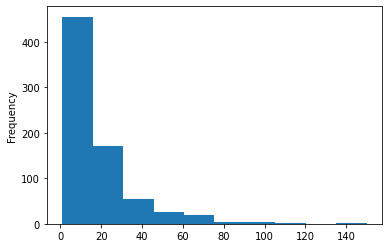

In [26]:
messages_with_scores.by_user_dialog_number.plot.hist()

<AxesSubplot:ylabel='Frequency'>

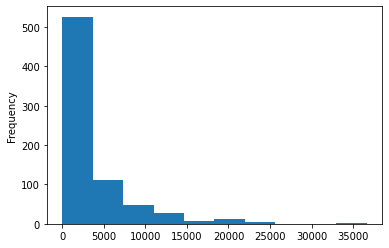

In [27]:
messages_with_scores.by_user_message_number.plot.hist()

In [28]:
messages_with_scores_many_data = messages_with_scores[messages_with_scores.by_user_message_number > 30]

In [29]:
messages_with_scores_many_data.shape

(680, 10)

In [31]:
messages_with_scores_many_data["text"] = messages_with_scores_many_data.user_texts.apply(lambda x: " ".join(map(str, x)))

In [32]:
messages_with_scores_many_data

,index,vk_id_encrypted,freud_install_time,who_score,diener_score,by_user_dialog_number,by_user_message_number,by_user_by_speakers_messages,user_texts,vk_ids_choised,text
0,2,435358060,2018-06-28 18:57:38,12.0,22.0,30,3099,"[[сегодня, да, я на собрании была, я его ещё в...","[сегодня, да, я на собрании была, я его ещё вч...",435358060,"сегодня да, я на собрании была я его ещё вчера..."
1,3,518613556,2018-07-17 11:38:02,23.0,24.0,13,2847,"[[Привет), Это промежуточный вариант, Тут не м...","[Привет), Это промежуточный вариант, Тут не мн...",518613556,Привет) Это промежуточный вариант Тут не много...
2,4,200269216,2018-08-28 13:33:33,10.0,9.0,12,405,"[[О, спасибо огромное) мне очень приятно что в...","[О, спасибо огромное) мне очень приятно что вы...",200269216,"О, спасибо огромное) мне очень приятно что вы ..."
3,5,305836538,2018-07-21 22:51:49,10.0,15.0,8,19599,"[[И все же у нас тоже кадык, Бро, я это знала....","[И все же у нас тоже кадык, Бро, я это знала. ...",305836538,"И все же у нас тоже кадык Бро, я это знала. Но..."
4,7,313691105,2018-07-31 10:25:13,14.0,13.0,8,1250,"[[Нашивки еще не делала, но пару раз вышивала ...","[Нашивки еще не делала, но пару раз вышивала н...",313691105,"Нашивки еще не делала, но пару раз вышивала на..."
...,...,...,...,...,...,...,...,...,...,...,...
733,851,540669219,2018-03-29 10:04:57,13.0,16.0,46,827,"[[Немного, 4, Я в курилке уже стою, Что твориш...","[Немного, 4, Я в курилке уже стою, Что творишь...",540669219,Немного 4 Я в курилке уже стою Что творишь? Ау...
734,852,354174379,2018-06-30 09:03:00,22.0,19.0,25,6445,"[[ахахахха, ахххаха окей, ща ноут освободится,...","[ахахахха, ахххаха окей, ща ноут освободится, ...",354174379,ахахахха ахххаха окей ща ноут освободится посм...
735,853,954555625,2018-08-27 01:15:08,16.0,15.0,17,1281,"[[Настя, на всякий случай, если ещё не в курсе...","[Настя, на всякий случай, если ещё не в курсе,...",954555625,"Настя, на всякий случай, если ещё не в курсе, ..."
736,854,849073825,2018-03-27 08:28:00,15.0,21.0,74,19788,"[[какие интересные боты в комментах обитают, д...","[какие интересные боты в комментах обитают, да...",849073825,какие интересные боты в комментах обитают да н...


In [33]:
pipe = Pipeline([
    ('tf', TfidfVectorizer(
               lowercase = True, 
               ngram_range = (1, 2), 
               max_df = 0.98,
               min_df = 2,
               tokenizer = wordpunct_tokenize
            )
    ),
    #('pca', TruncatedSVD(500)), 
    ('lr', Ridge())
])

In [34]:
import numpy as np
from sklearn.model_selection import KFold

def base_estimations(target="who_score"):
    scores = {"mae":[], "mse":[], "r":[], "pearson": []}
    kf = KFold(n_splits=5)
    for train, test in kf.split(messages_with_scores_many_data):
        pipe.fit(messages_with_scores_many_data.text.iloc[train], messages_with_scores_many_data[target].iloc[train])
        predicted_y = pipe.predict(messages_with_scores_many_data.text.iloc[test])
        mae, mse, r, pear = get_metrics(messages_with_scores_many_data[target].iloc[test], predicted_y)
        scores["mae"].append(mae) 
        scores["mse"].append(mse)
        scores["r"].append(r)
        scores["pearson"].append(pear)
        
        plot_two_distributions(messages_with_scores_many_data[target].iloc[test], predicted_y)
    for name, values in scores.items():
        print()
        print("Result")
        print(f"{name}: {sum(values)/len(values)}")

Расчет базовой метерики на простом пайплайне из тф-идф и ридж регрессии. Используется кросс-валидация на 5 фолдов.

## Who score 


Report:
mean_squared_error: 20.8809
mean_absolute_error: 3.8468
r2_score 0.139
pearsonr_corr: 0.4007, pearsonr_p: 0.0
spearman_corr: 0.431, spearman_p: 0.0



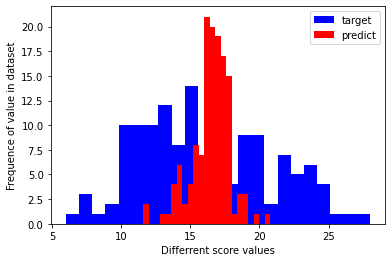

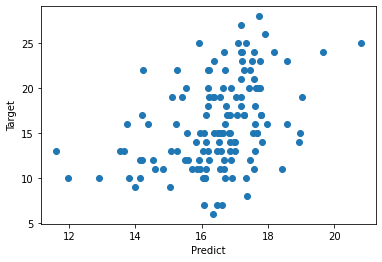

Report:
mean_squared_error: 15.4875
mean_absolute_error: 3.1734
r2_score 0.012
pearsonr_corr: 0.1677, pearsonr_p: 0.051
spearman_corr: 0.15, spearman_p: 0.0814



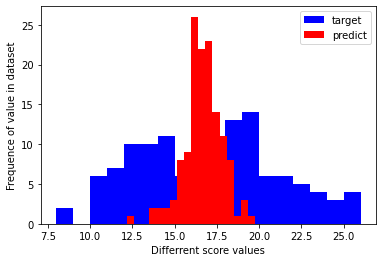

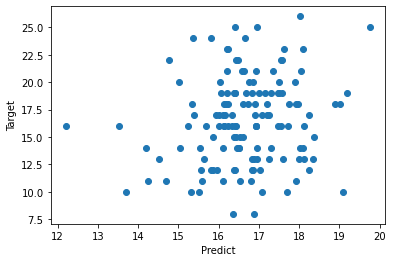

Report:
mean_squared_error: 25.1078
mean_absolute_error: 4.039
r2_score 0.0592
pearsonr_corr: 0.2459, pearsonr_p: 0.0039
spearman_corr: 0.1877, spearman_p: 0.0286



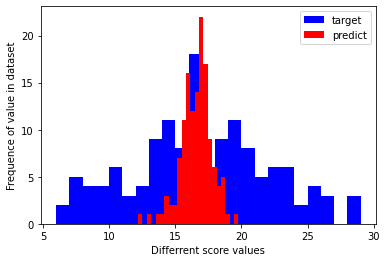

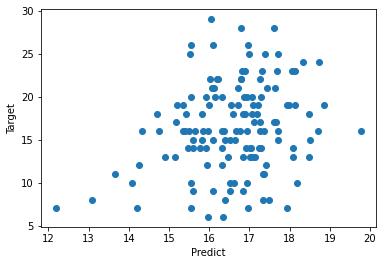

Report:
mean_squared_error: 25.8692
mean_absolute_error: 4.1623
r2_score -0.0234
pearsonr_corr: 0.1318, pearsonr_p: 0.1261
spearman_corr: 0.1311, spearman_p: 0.1282



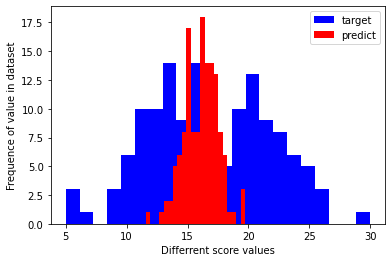

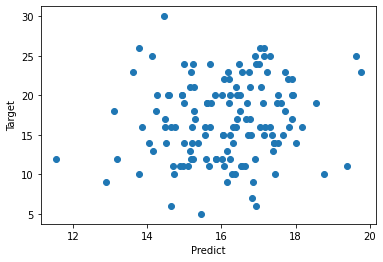

Report:
mean_squared_error: 20.952
mean_absolute_error: 3.7829
r2_score 0.0228
pearsonr_corr: 0.1768, pearsonr_p: 0.0395
spearman_corr: 0.1008, spearman_p: 0.2429



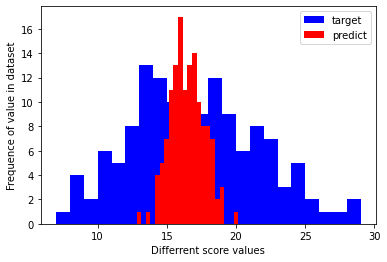

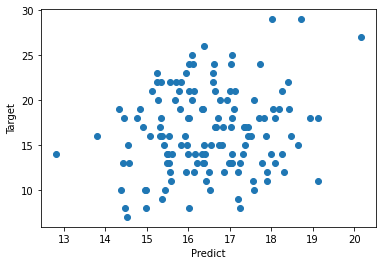


Result
mae: 21.659480000000002

Result
mse: 3.8008800000000003

Result
r: 0.04192

Result
pearson: 0.22458071752773812


In [35]:
base_estimations()

## Diener score

Report:
mean_squared_error: 43.2822
mean_absolute_error: 5.5375
r2_score 0.0679
pearsonr_corr: 0.261, pearsonr_p: 0.0021
spearman_corr: 0.2654, spearman_p: 0.0018



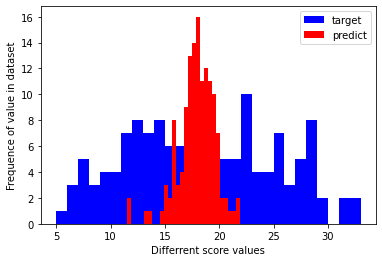

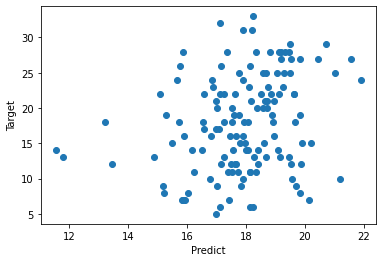

Report:
mean_squared_error: 40.6642
mean_absolute_error: 5.3875
r2_score -0.0005
pearsonr_corr: 0.1978, pearsonr_p: 0.021
spearman_corr: 0.1856, spearman_p: 0.0305



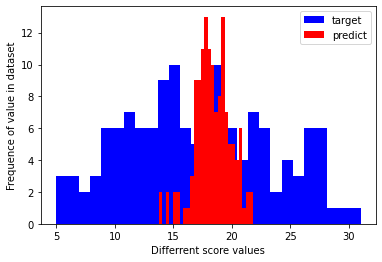

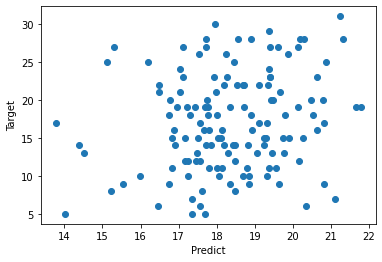

Report:
mean_squared_error: 44.3981
mean_absolute_error: 5.4537
r2_score 0.0394
pearsonr_corr: 0.225, pearsonr_p: 0.0084
spearman_corr: 0.219, spearman_p: 0.0104



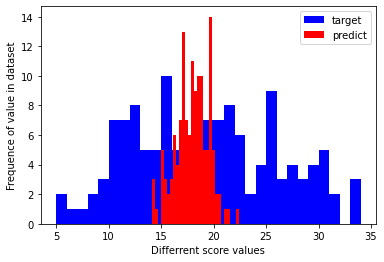

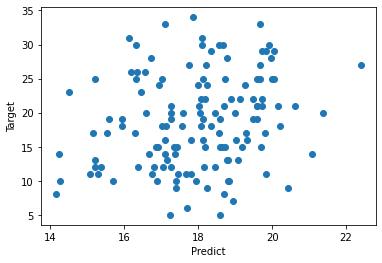

Report:
mean_squared_error: 45.771
mean_absolute_error: 5.7219
r2_score 0.0324
pearsonr_corr: 0.1975, pearsonr_p: 0.0212
spearman_corr: 0.2015, spearman_p: 0.0186



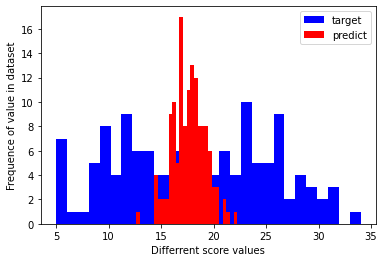

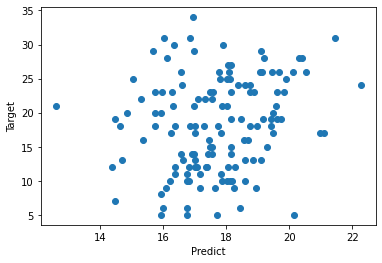

Report:
mean_squared_error: 40.9267
mean_absolute_error: 5.3156
r2_score -0.0382
pearsonr_corr: 0.0822, pearsonr_p: 0.3415
spearman_corr: 0.061, spearman_p: 0.4809



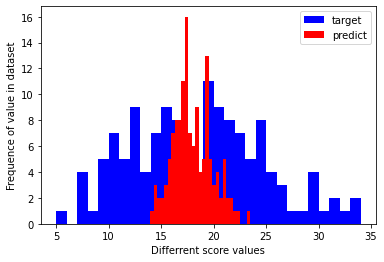

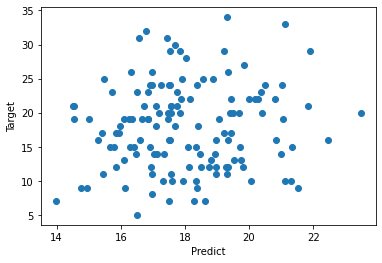


Result
mae: 43.00843999999999

Result
mse: 5.48324

Result
r: 0.0202

Result
pearson: 0.19271123569757545


In [36]:
base_estimations(target="diener_score")

In [39]:
def with_augs_estimations(target = "who_score", augs_coef = 2):
    scores = {"mae":[], "mse":[], "r":[], "pearson": []}
    kf = KFold(n_splits=5)
    for train, test in kf.split(messages_with_scores_many_data):
        augmented_data = {"source": [], "target": []}
        for score, texts in zip(messages_with_scores_many_data[target].iloc[train].tolist(), messages_with_scores_many_data.by_user_by_speakers_messages.iloc[train].tolist()):
            current_pos = 0
            bound = int(len(texts) / augs_coef)
            for part in range(augs_coef):
                text = " ".join([str(m) for mes in texts[current_pos: current_pos + bound] for m in mes])
                augmented_data["source"].append(text)
                augmented_data["target"].append(score)
                current_pos += bound
        
        augmented_data = pd.DataFrame(augmented_data)        
        pipe.fit(augmented_data.source, augmented_data.target)
        predicted_y = pipe.predict(messages_with_scores_many_data.text.iloc[test])
        mae, mse, r, pear = get_metrics(messages_with_scores_many_data[target].iloc[test], predicted_y)
        scores["mae"].append(mae) 
        scores["mse"].append(mse)
        scores["r"].append(r)
        scores["pearson"].append(pear)
        
        plot_two_distributions(messages_with_scores_many_data[target].iloc[test], predicted_y)
    print()
    print("Result")
    for name, values in scores.items():
        print(f"{name}: {sum(values)/len(values)}")

Расчет метерики на простом пайплайне из тф-идф и ридж регрессии с аугментацией. 
Суть аугментации: сообщения каждого пользователя делятся на n равных частьей без привязки к диалогам (по дефолту 2 части). 
Так как каждая часть относится к одному и тому же пользователю, то она становится независимым тренировочным примеров с таргетом равным таргету пользователя. Таким образом выборка увеличивается в n-раз. 
Используется кросс-валидация на 5 фолдов.

## Who score

Report:
mean_squared_error: 20.9972
mean_absolute_error: 3.8426
r2_score 0.1342
pearsonr_corr: 0.3794, pearsonr_p: 0.0
spearman_corr: 0.3797, spearman_p: 0.0



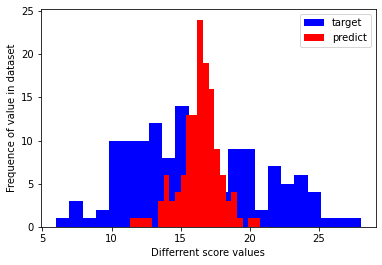

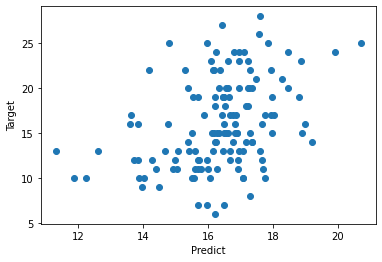

Report:
mean_squared_error: 15.7041
mean_absolute_error: 3.1974
r2_score -0.0018
pearsonr_corr: 0.1544, pearsonr_p: 0.0727
spearman_corr: 0.1445, spearman_p: 0.0932



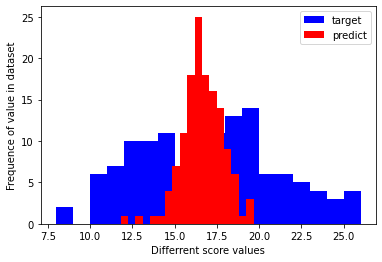

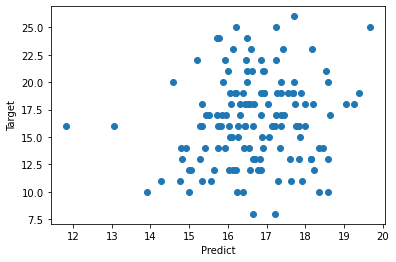

Report:
mean_squared_error: 24.9821
mean_absolute_error: 4.0142
r2_score 0.0639
pearsonr_corr: 0.2541, pearsonr_p: 0.0028
spearman_corr: 0.2156, spearman_p: 0.0117



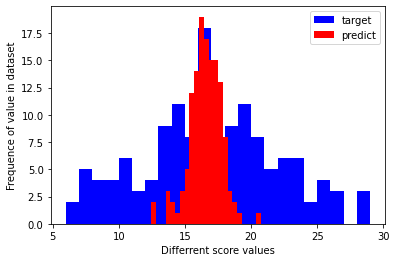

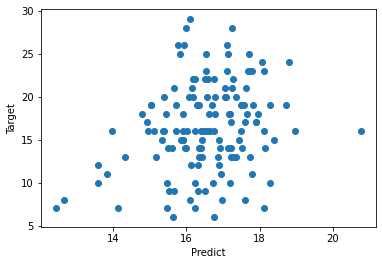

Report:
mean_squared_error: 26.056
mean_absolute_error: 4.1839
r2_score -0.0308
pearsonr_corr: 0.1289, pearsonr_p: 0.1348
spearman_corr: 0.1211, spearman_p: 0.1603



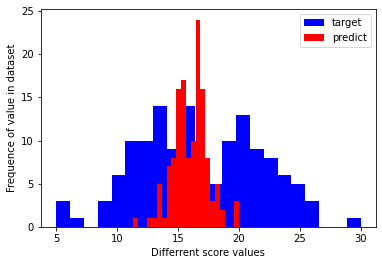

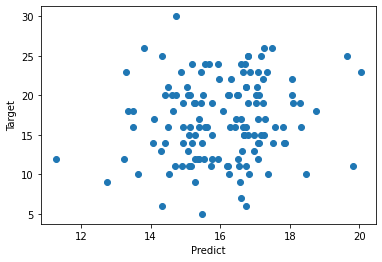

Report:
mean_squared_error: 21.2533
mean_absolute_error: 3.808
r2_score 0.0087
pearsonr_corr: 0.1592, pearsonr_p: 0.064
spearman_corr: 0.0868, spearman_p: 0.3149



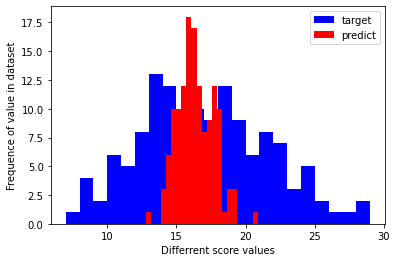

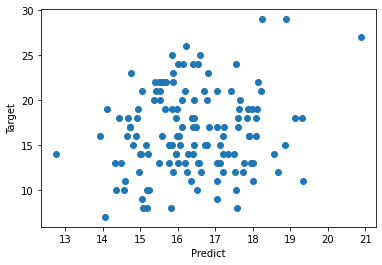


Result
mae: 21.79854
mse: 3.80922
r: 0.03484
pearson: 0.2152089483575816


In [40]:
with_augs_estimations()

Report:
mean_squared_error: 21.08
mean_absolute_error: 3.8342
r2_score 0.1308
pearsonr_corr: 0.3707, pearsonr_p: 0.0
spearman_corr: 0.3745, spearman_p: 0.0



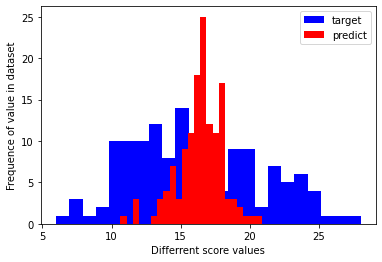

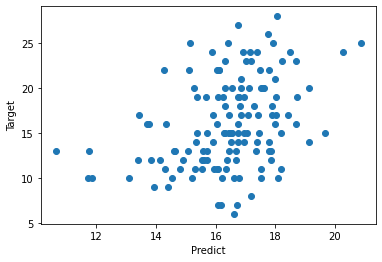

Report:
mean_squared_error: 16.2118
mean_absolute_error: 3.2661
r2_score -0.0342
pearsonr_corr: 0.1117, pearsonr_p: 0.1956
spearman_corr: 0.0994, spearman_p: 0.2498



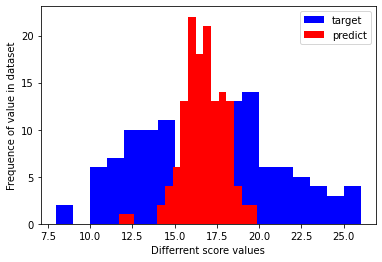

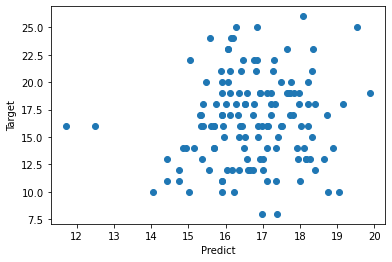

Report:
mean_squared_error: 24.9732
mean_absolute_error: 4.008
r2_score 0.0643
pearsonr_corr: 0.2549, pearsonr_p: 0.0028
spearman_corr: 0.2309, spearman_p: 0.0068



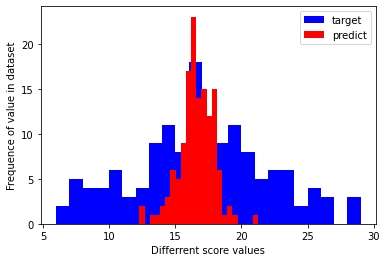

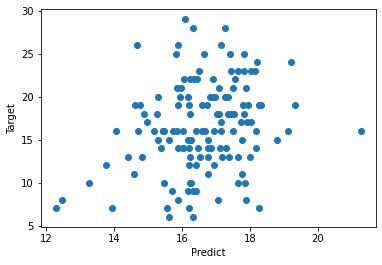

Report:
mean_squared_error: 26.2621
mean_absolute_error: 4.1959
r2_score -0.0389
pearsonr_corr: 0.1308, pearsonr_p: 0.1292
spearman_corr: 0.1256, spearman_p: 0.1451



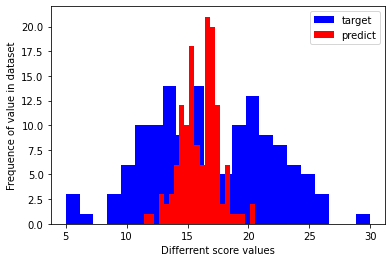

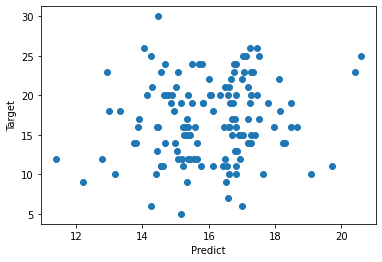

Report:
mean_squared_error: 21.2322
mean_absolute_error: 3.7803
r2_score 0.0097
pearsonr_corr: 0.1634, pearsonr_p: 0.0574
spearman_corr: 0.0961, spearman_p: 0.2656



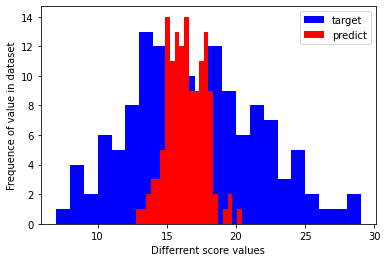

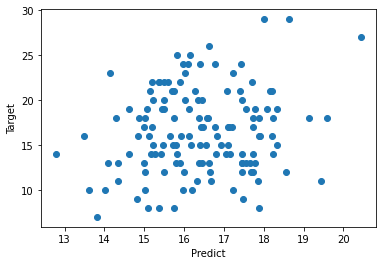


Result
mae: 21.95186
mse: 3.8168999999999995
r: 0.026339999999999995
pearson: 0.20626747617862567


In [41]:
with_augs_estimations(augs_coef = 3)

Report:
mean_squared_error: 20.9483
mean_absolute_error: 3.7922
r2_score 0.1363
pearsonr_corr: 0.3727, pearsonr_p: 0.0
spearman_corr: 0.3838, spearman_p: 0.0



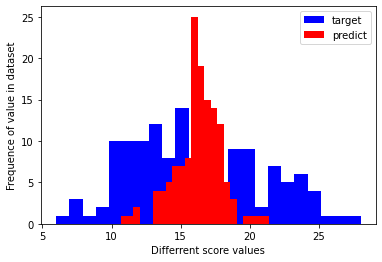

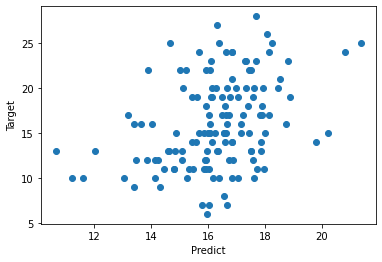

Report:
mean_squared_error: 16.1646
mean_absolute_error: 3.2436
r2_score -0.0311
pearsonr_corr: 0.1371, pearsonr_p: 0.1116
spearman_corr: 0.127, spearman_p: 0.1406



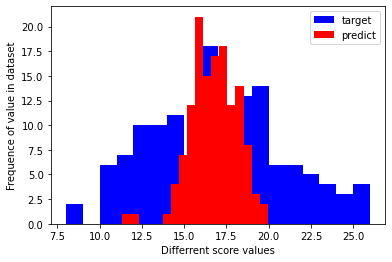

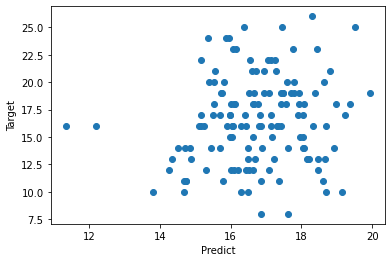

Report:
mean_squared_error: 25.1627
mean_absolute_error: 4.0235
r2_score 0.0572
pearsonr_corr: 0.2416, pearsonr_p: 0.0046
spearman_corr: 0.2121, spearman_p: 0.0132



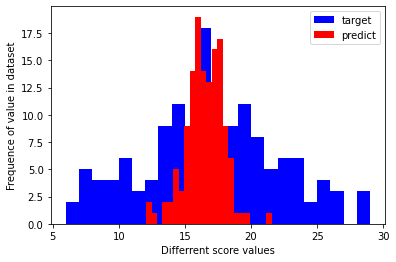

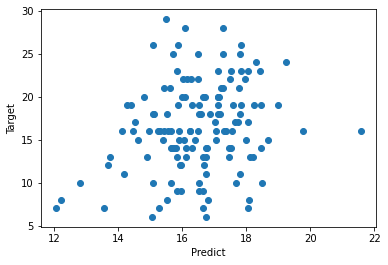

Report:
mean_squared_error: 26.4709
mean_absolute_error: 4.2002
r2_score -0.0472
pearsonr_corr: 0.1278, pearsonr_p: 0.1381
spearman_corr: 0.1179, spearman_p: 0.1718



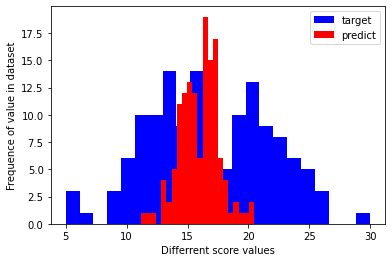

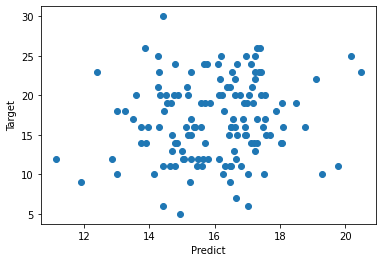

Report:
mean_squared_error: 21.6952
mean_absolute_error: 3.8171
r2_score -0.0119
pearsonr_corr: 0.1425, pearsonr_p: 0.098
spearman_corr: 0.0712, spearman_p: 0.4099



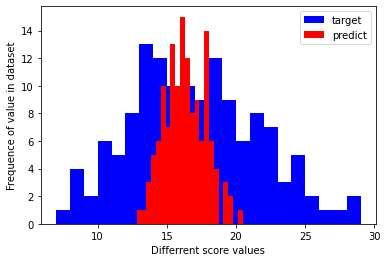

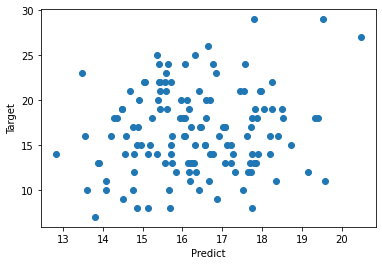


Result
mae: 22.08834
mse: 3.81532
r: 0.02066
pearson: 0.20433393369583883


In [42]:
with_augs_estimations(augs_coef = 4)

## Diener score

Report:
mean_squared_error: 43.8818
mean_absolute_error: 5.5598
r2_score 0.055
pearsonr_corr: 0.2366, pearsonr_p: 0.0056
spearman_corr: 0.2477, spearman_p: 0.0036



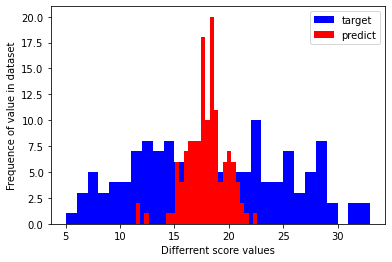

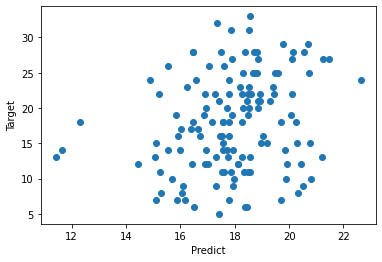

Report:
mean_squared_error: 40.4809
mean_absolute_error: 5.3626
r2_score 0.004
pearsonr_corr: 0.2062, pearsonr_p: 0.016
spearman_corr: 0.1922, spearman_p: 0.025



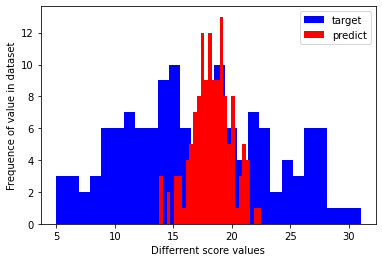

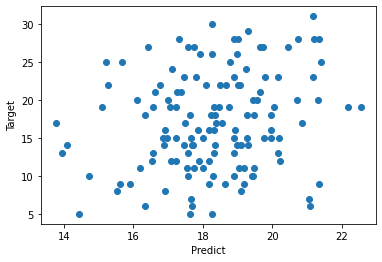

Report:
mean_squared_error: 43.9709
mean_absolute_error: 5.4598
r2_score 0.0486
pearsonr_corr: 0.25, pearsonr_p: 0.0033
spearman_corr: 0.2475, spearman_p: 0.0037



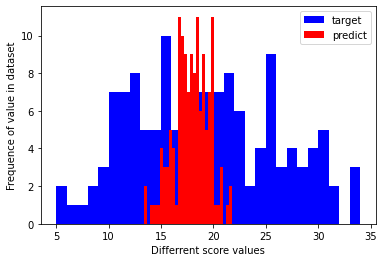

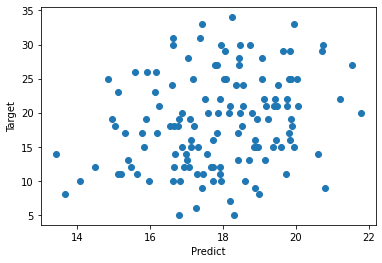

Report:
mean_squared_error: 45.5487
mean_absolute_error: 5.6797
r2_score 0.0371
pearsonr_corr: 0.2135, pearsonr_p: 0.0126
spearman_corr: 0.2087, spearman_p: 0.0148



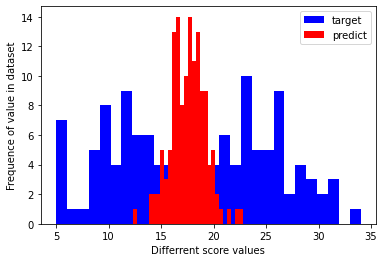

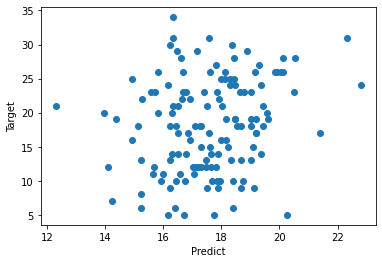

Report:
mean_squared_error: 40.7011
mean_absolute_error: 5.3081
r2_score -0.0325
pearsonr_corr: 0.0969, pearsonr_p: 0.2618
spearman_corr: 0.0529, spearman_p: 0.5407



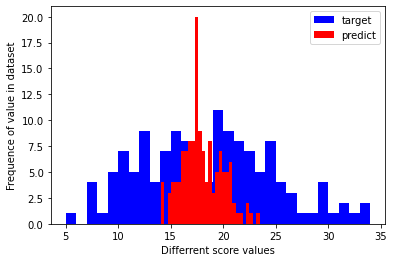

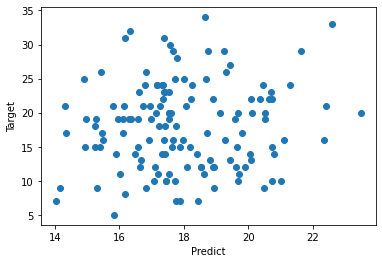


Result
mae: 42.91668
mse: 5.474
r: 0.022439999999999998
pearson: 0.2006202823113124


In [43]:
with_augs_estimations(target="diener_score")

Report:
mean_squared_error: 44.3524
mean_absolute_error: 5.5772
r2_score 0.0449
pearsonr_corr: 0.2225, pearsonr_p: 0.0092
spearman_corr: 0.2233, spearman_p: 0.009



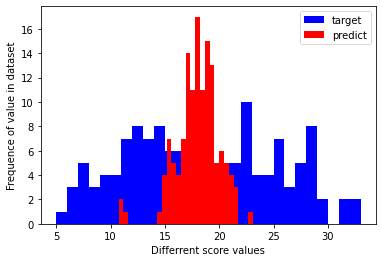

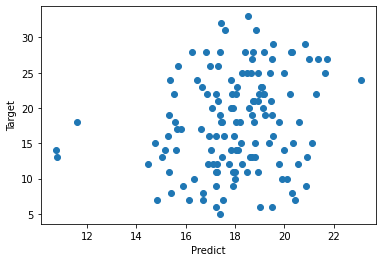

Report:
mean_squared_error: 41.0975
mean_absolute_error: 5.4014
r2_score -0.0112
pearsonr_corr: 0.192, pearsonr_p: 0.0251
spearman_corr: 0.1823, spearman_p: 0.0336



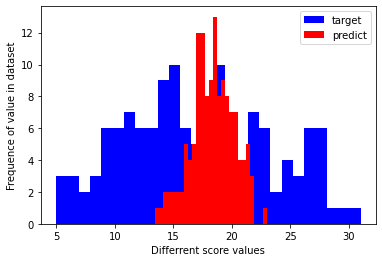

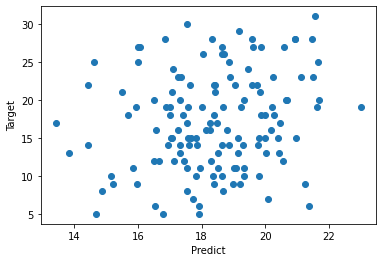

Report:
mean_squared_error: 43.456
mean_absolute_error: 5.3847
r2_score 0.0598
pearsonr_corr: 0.272, pearsonr_p: 0.0014
spearman_corr: 0.2795, spearman_p: 0.001



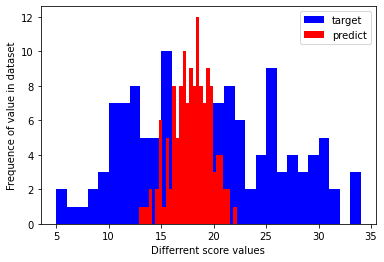

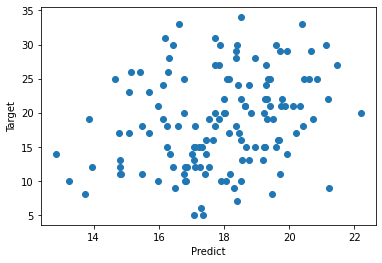

Report:
mean_squared_error: 46.304
mean_absolute_error: 5.7231
r2_score 0.0211
pearsonr_corr: 0.1844, pearsonr_p: 0.0317
spearman_corr: 0.177, spearman_p: 0.0393



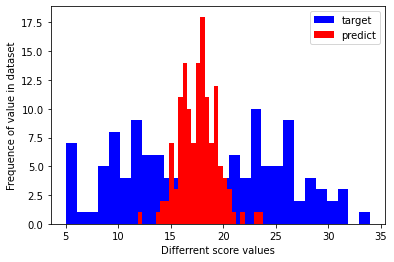

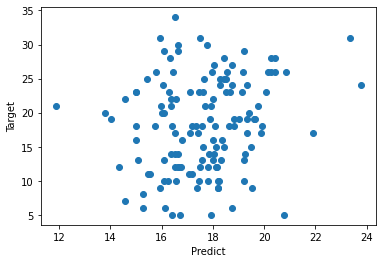

Report:
mean_squared_error: 40.5769
mean_absolute_error: 5.3132
r2_score -0.0294
pearsonr_corr: 0.1154, pearsonr_p: 0.181
spearman_corr: 0.0851, spearman_p: 0.3245



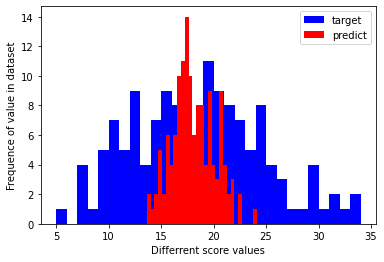

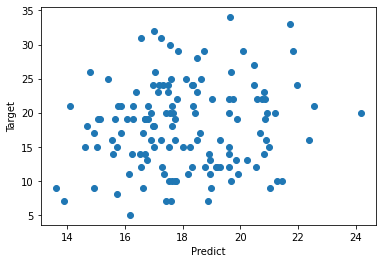


Result
mae: 43.15736
mse: 5.47992
r: 0.017040000000000003
pearson: 0.19726443704066604


In [44]:
with_augs_estimations(target="diener_score", augs_coef = 3)

Report:
mean_squared_error: 44.2789
mean_absolute_error: 5.5649
r2_score 0.0464
pearsonr_corr: 0.2225, pearsonr_p: 0.0092
spearman_corr: 0.2198, spearman_p: 0.0101



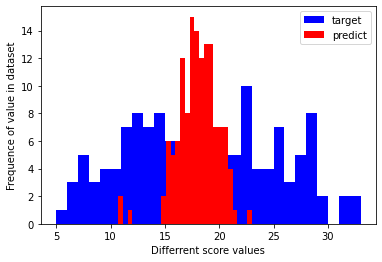

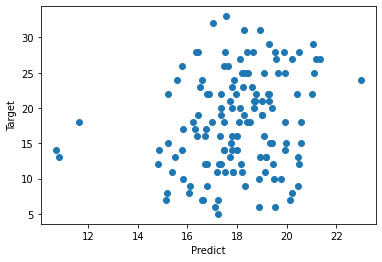

Report:
mean_squared_error: 40.6588
mean_absolute_error: 5.3595
r2_score -0.0004
pearsonr_corr: 0.212, pearsonr_p: 0.0132
spearman_corr: 0.1925, spearman_p: 0.0248



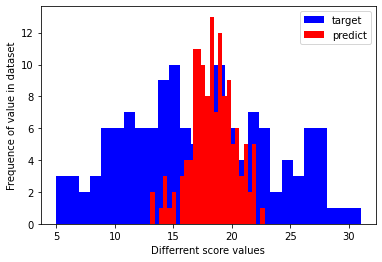

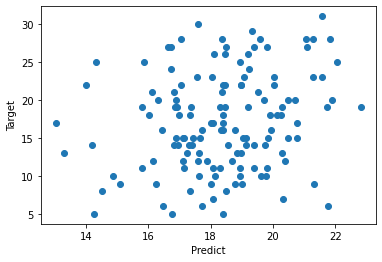

Report:
mean_squared_error: 43.4744
mean_absolute_error: 5.408
r2_score 0.0594
pearsonr_corr: 0.2701, pearsonr_p: 0.0015
spearman_corr: 0.2849, spearman_p: 0.0008



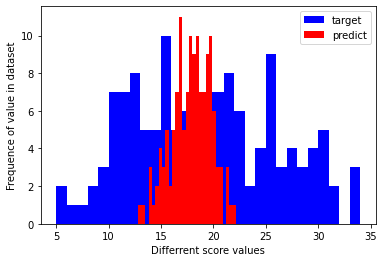

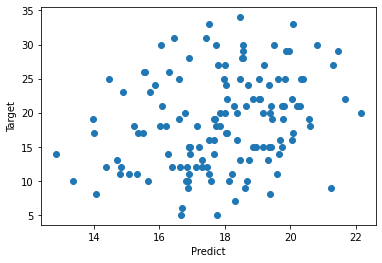

Report:
mean_squared_error: 47.1052
mean_absolute_error: 5.7793
r2_score 0.0042
pearsonr_corr: 0.1597, pearsonr_p: 0.0633
spearman_corr: 0.1611, spearman_p: 0.0609



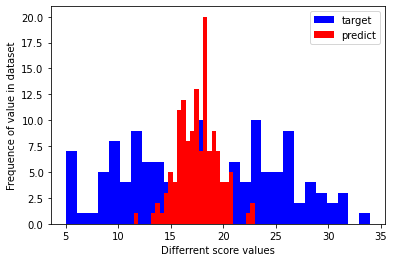

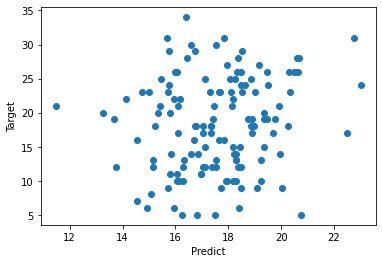

Report:
mean_squared_error: 40.7597
mean_absolute_error: 5.3443
r2_score -0.034
pearsonr_corr: 0.1077, pearsonr_p: 0.2122
spearman_corr: 0.0773, spearman_p: 0.3708



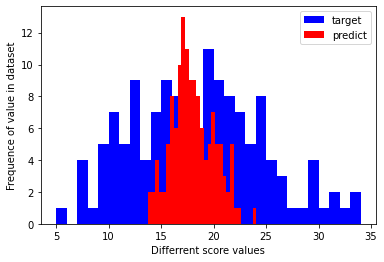

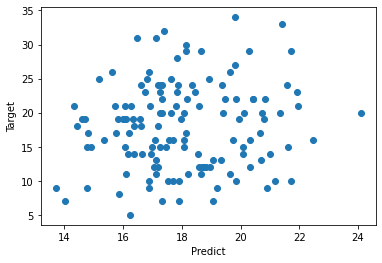


Result
mae: 43.2554
mse: 5.4912
r: 0.015119999999999998
pearson: 0.1943953251585397


In [45]:
with_augs_estimations(target="diener_score", augs_coef = 4)